# Feature vector를 input data로 사용하는 LightGBM 모델

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

# Sklearn Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    auc
)

## 모델 학습

In [8]:
# 파일 경로 설정
train_feature_file = f"{base_path}/ML_FeatureVector/train_features.npy"
train_label_file = f"{base_path}/ML_FeatureVector/train_labels.npy"
dev_feature_file = f"{base_path}/ML_FeatureVector/dev_features.npy"
dev_label_file = f"{base_path}/ML_FeatureVector/dev_labels.npy"
test_feature_file = f"{base_path}/ML_FeatureVector/test_features.npy"
test_label_file = f"{base_path}/ML_FeatureVector/test_labels.npy"

output_csv = "./prediction_output_lgbm.csv"  # 결과 저장 경로

# Train 및 Dev 데이터 로드
train_features = np.load(train_feature_file)
train_labels = np.load(train_label_file)
dev_features = np.load(dev_feature_file)
dev_labels = np.load(dev_label_file)

# Train-Dev 합치기
X_train = np.vstack((train_features, dev_features))
y_train = np.hstack((train_labels, dev_labels))

# Test 데이터 로드
X_test = np.load(test_feature_file)
y_test = np.load(test_label_file)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)

# LightGBM 모델 설정
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20
}

# LightGBM 모델 학습
model = lgb.train(params, train_data, num_boost_round=100)

# Test 데이터 예측
predictions = (model.predict(X_test) > 0.5).astype(int)

# 원래 label과 예측된 label을 묶어서 저장
output_data = pd.DataFrame({
    "label": y_test,
    "predicted_label": predictions
})
output_data.to_csv(output_csv, index=False)

# print(f"Prediction results saved to {output_csv}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 45425, number of negative: 45334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 90759, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500501 -> initscore=0.002005
[LightGBM] [Info] Start training from score 0.002005


# 모델 성능 평가

In [9]:
# Classification report

# 원래 라벨과 예측된 라벨 추출
true_labels = output_data['label']
predicted_labels = output_data['predicted_label']

# Classification Report 생성
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])

# 출력
print("[ DNABERT + LightGBM ]",'\n')
print("Classification Report:")
print(report)

[ DNABERT + LightGBM ] 

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.91      0.93      8054
     Class 1       0.91      0.96      0.94      7963

    accuracy                           0.93     16017
   macro avg       0.94      0.93      0.93     16017
weighted avg       0.94      0.93      0.93     16017



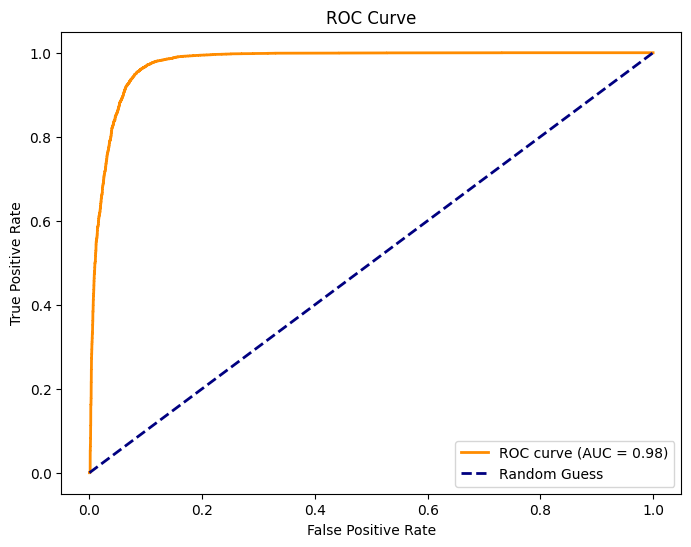

AUC (Area Under the Curve): 0.9764


In [11]:
# Test 데이터 예측 (확률 값 계산)
prediction_probabilities = model.predict(X_test)

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, prediction_probabilities)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

# AUC 출력
print(f"AUC (Area Under the Curve): {roc_auc:.4f}")